In [1]:
import tensorflow as tf
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
import seaborn as sns
from keras.utils import to_categorical

2023-07-23 20:18:21.076158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 20:18:23.286967: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = pl.read_csv('SPAM text message 20170820 - Data.csv')

In [3]:
data

Category,Message
str,str
"""ham""","""Go until juron…"
"""ham""","""Ok lar... Joki…"
"""spam""","""Free entry in …"
"""ham""","""U dun say so e…"
"""ham""","""Nah I don't th…"
"""spam""","""FreeMsg Hey th…"
"""ham""","""Even my brothe…"
"""ham""","""As per your re…"
"""spam""","""WINNER!! As a …"


In [4]:
data.groupby('Category').count()

Category,count
str,u32
"""spam""",747
"""ham""",4825


In [5]:
ham_msg = data.filter(pl.col('Category') == 'ham')
spam_msg = data.filter(pl.col('Category') == 'spam')

In [6]:
#randomly taking data from ham_ msg
ham_msg = ham_msg.sample(n=len(spam_msg))

In [7]:
print(ham_msg.shape, spam_msg.shape)

(747, 2) (747, 2)


In [8]:
data

Category,Message
str,str
"""ham""","""Go until juron…"
"""ham""","""Ok lar... Joki…"
"""spam""","""Free entry in …"
"""ham""","""U dun say so e…"
"""ham""","""Nah I don't th…"
"""spam""","""FreeMsg Hey th…"
"""ham""","""Even my brothe…"
"""ham""","""As per your re…"
"""spam""","""WINNER!! As a …"


In [9]:
balanced_data = ham_msg.vstack(spam_msg)
balanced_data = balanced_data.with_columns(
    pl.when(pl.col("Category") == 'spam').then(1).otherwise(0).alias('Category')
)

In [10]:
balanced_data

Category,Message
i32,str
0,"""R u here yet? …"
0,"""Ok lar... Joki…"
0,"""U dun say so e…"
0,"""Nah I don't th…"
0,"""Kindly send so…"
0,"""Long after I q…"
0,"""Die... I accid…"
0,"""I've been sear…"
0,"""I HAVE A DATE …"


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(
    balanced_data['Message'], 
    balanced_data['Category'],
    test_size=0.2,
    random_state=42
)

In [12]:
X_train = np.array(X_train, dtype=np.chararray)
X_test = np.array(X_test, dtype=np.chararray)
X_train

array(["Sorry, I'll call later", 'Cuz ibored. And don wanna study',
       'Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?',
       ...,
       'You have an important customer service announcement from PREMIER. Call FREEPHONE 0800 542 0578 now!',
       'URGENT! Your Mobile number has been awarded with a £2000 prize GUARANTEED. Call 09061790126 from land line. Claim 3030. Valid 12hrs only 150ppm',
       'How come it takes so little time for a child who is afraid of the dark to become a teenager who wants to stay out all night?'],
      dtype=object)

In [13]:
max_features = 5000  # Maximum vocab size.
max_len = 50

# Create the layer.
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_len
)
vectorize_layer.adapt(X_test)
vectorizd_X_test = vectorize_layer(X_test)

vectorize_layer.adapt(X_train)
vectorizd_X_train = vectorize_layer(X_train)

2023-07-23 20:18:28.541266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-23 20:18:29.332411: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
Y_train = np.array(Y_train, dtype=np.int64)
Y_test = np.array(Y_test, dtype=np.int64)

In [22]:
#model
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(
            120, 
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.L1(),
            ),
        tf.keras.layers.Dense(
            120, 
            activation='relu',            
            kernel_regularizer=tf.keras.regularizers.L1(),
            ),
        tf.keras.layers.Dense(
            120, 
            activation='relu',            
            kernel_regularizer=tf.keras.regularizers.L1(),
            ),
        tf.keras.layers.Dense(
            1,
            activation='sigmoid'
            )
    ]
)

In [29]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy()],
    optimizer = tf.keras.optimizers.Adam()
)

In [30]:

print(vectorizd_X_train)
history = model.fit(
    vectorizd_X_train,
    Y_train,
    epochs=100,
)

tf.Tensor(
[[ 153   94    6 ...    0    0    0]
 [3394 3029   12 ...    0    0    0]
 [ 308 1590   89 ...    0    0    0]
 ...
 [   3   15  150 ...    0    0    0]
 [  67    8   33 ...    0    0    0]
 [  89   86   28 ...    0    0    0]], shape=(1195, 50), dtype=int64)
Epoch 1/100


/home/mohamed/anaconda3/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - 2s 6ms/step - loss: 3.8853 - accuracy: 0.0452
Epoch 2/100
38/38 [==============================] - 0s 5ms/step - loss: 3.4012 - accuracy: 0.0368
Epoch 3/100
38/38 [==============================] - 0s 5ms/step - loss: 3.1478 - accuracy: 0.0385
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 2.9561 - accuracy: 0.0285
Epoch 5/100
38/38 [==============================] - 0s 4ms/step - loss: 2.7766 - accuracy: 0.0268
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 2.6024 - accuracy: 0.0259
Epoch 7/100
38/38 [==============================] - 0s 5ms/step - loss: 2.5066 - accuracy: 0.0209
Epoch 8/100
38/38 [==============================] - 0s 4ms/step - loss: 2.3129 - accuracy: 0.0268
Epoch 9/100
38/38 [==============================] - 0s 5ms/step - loss: 2.1968 - accuracy: 0.0218
Epoch 10/100
38/38 [==============================] - 0s 6ms/step - loss: 2.0466 - accuracy: 0.0134
Epoch 11/100
38/38 [=

KeyboardInterrupt: 

In [ ]:
model.evaluate(
    vectorizd_X_test,
    Y_test
)

10/10 [==============================] - 0s 3ms/step - loss: 4.2121 - accuracy: 0.0000e+00


[4.212086200714111, 0.0]

Text(0.5, 0, 'epoch')

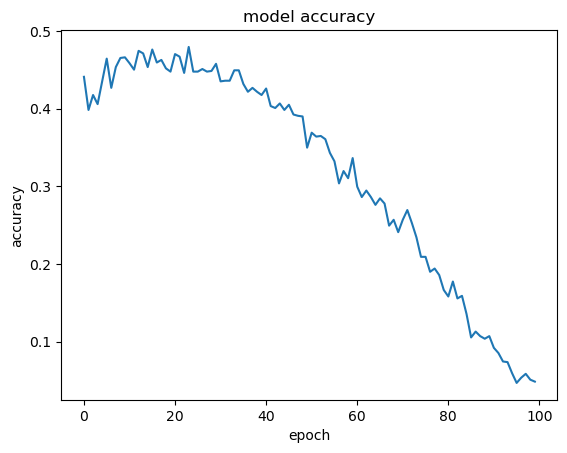

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [ ]:
predict_msg = [
    "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
    "Ok lar... Joking wif u oni...",
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [ ]:
vectorize_layer.adapt(predict_msg)
vectorizd_predict_msg = vectorize_layer(predict_msg)

model.predict(vectorizd_predict_msg)

1/1 [==============================] - 0s 77ms/step


array([[0.22428803],
       [0.20431146],
       [0.23703411]], dtype=float32)